В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm_bright_test = ListedColormap(['#FFA833','#33E0FF']) # '5EFF33', '#FFF933'
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

np.random.seed(1)

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y, color_map=cm_bright):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=color_map)

In [29]:
class SoftmaxNeuralNet:

  def __init__(self, layer_dims, normalize=True, learning_rate=0.01, num_iter=30000, precision=None):
    self.learning_rate = learning_rate
    self.num_iter = num_iter
    self.normalize = normalize
    self.layer_dims = layer_dims
    self.precision = precision

  def __normalize(self, X, mean=None, std=None):
    n = X.shape[0]

    if mean is None:
      mean = np.mean(X, axis=1).reshape((n, 1))

    if std is None:
      std = np.std(X, axis=1).reshape((n, 1))
      
    X_new = (X - mean) / std**2
    
    return X_new, mean, std

  def __sigmoid(self, Z):
    return 1 / (1 + np.exp(-Z))

  def __sigmoid_derivative(self, Z):
    s = self.__sigmoid(Z)
    return s*(1 - s)

  def __relu(self, Z):
    Z = np.array(Z, copy=True)
    Z[Z < 0] = 0
    return Z

  def __relu_derivative(self, Z):
    dZ = np.ones(Z.shape)
    dZ[Z <=0 ] = 0
    return dZ

  def __softmax(self, Z):
    eZ = np.exp(Z)
    return eZ / np.sum(eZ, axis=0)

  def __softmax_derivative(self, Z):
    #s = softmax.reshape(-1, 1)
    return np.diagflat(Z) - np.dot(Z, Z.T)

  def __initialize_parameters(self):
    layer_dims = self.layer_dims
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
      parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
      parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    self.parameters = parameters

  def __forward_linear_activation(self, A_prev, W, b, activation):

    # linear forward
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)

    # activation forward
    if activation == 'sigmoid':
      A = self.__sigmoid(Z)
    
    if activation == 'relu':
      A = self.__relu(Z)
    
    if activation == 'softmax':
      A = self.__softmax(Z)
    
    activation_cache = Z

    cache = (linear_cache, activation_cache)

    return A, cache

  def __multilayer_forward(self, X):
    parameters = self.parameters
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
      A_prev = A
      A, cache = self.__forward_linear_activation(
        A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation='relu')
      caches.append(cache)

    AL, cache = self.__forward_linear_activation(
      A, parameters["W"+str(L)], parameters["b"+str(L)], activation='sigmoid')
    caches.append(cache)

    assert(AL.shape == (1, X.shape[1]))

    return AL, caches

  def __backward_linear_activation(self, dA, cache, activation):

    linear_cache, activation_cache = cache

    # activation backward
    Z = activation_cache
    
    if activation == 'sigmoid':
      dZ = dA * self.__sigmoid_derivative(Z)

    if activation == 'relu':
      dZ = dA * self.__relu_derivative(Z)

    if activation == 'softmax':
      dZ = dA * self.__softmax_derivative(Z)

    # linear backward
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

  def __multilayer_backward(self, X, Y, caches):
    grads = {}
    AL = X
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # sigmoid
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    #dAL = - np.multiply(AL, np.log(Y)).sum() / Y.shape[0]
    
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = \
      self.__backward_linear_activation(dAL, current_cache, activation='sigmoid')

    for l in reversed(range(L-1)):
      current_cache = caches[l]
      dA_prev_temp, dW_temp, db_temp = \
        self.__backward_linear_activation(grads["dA" + str(l + 1)], current_cache, activation='relu')
      grads["dA" + str(l)] = dA_prev_temp
      grads["dW" + str(l + 1)] = dW_temp
      grads["db" + str(l + 1)] = db_temp

    return grads

  def compute_cost(self, A, Y):
    m = Y.shape[1]
    res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
    J = -(1 / m) * np.sum(res)
    return J

  def cross_entropy(self, A, Y):
    return - np.sum(np.log(A) * (Y), axis=1)

  def __update_parameters(self, grads):
    parameters = self.parameters
    learning_rate = self.learning_rate
    L = len(parameters) // 2

    for l in range(L):
      parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
      parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    self.parameters = parameters

  def fit(self, X_vert, Y_vert, print_cost=True):

    X, Y = X_vert.T, Y_vert.T

    if self.normalize:
      X, self.__mean, self.__std = self.__normalize(X)

    costs = []

    self.__initialize_parameters()

    for i in range(0, self.num_iter):

      AL, caches = self.__multilayer_forward(X)

      cost = self.compute_cost(AL, Y)

      grads = self.__multilayer_backward(AL, Y, caches)

      self.__update_parameters(grads)

      if print_cost and i % 100 == 0:
        print("Cost after iteration %i: %f" % (i, cost))
      if print_cost and i % 100 == 0:
        costs.append(cost)

      if len(costs) > 1 and self.precision != None and np.abs(costs[-2] - costs[-1]) < self.precision:
        print('Stopping gradient descent ...')
        break

    if print_cost:
      plt.plot(costs)
      plt.ylabel("Cost")
      plt.xlabel("Iteration, *100")
      plt.show()

  def predict_proba(self, X_vert):
    X = X_vert.T
    if self.normalize:
      X, _, _ = self.__normalize(X, self.__mean, self.__std)

    probs = self.__multilayer_forward(X)[0]

    return np.column_stack((probs.T, 1 - probs.T))

  def predict(self, X_vert):
    positive_probs = self.predict_proba(X_vert)[:, 0]
    return (positive_probs >= 0.5).astype(int)


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [24]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("../Logistic Regression/data/tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


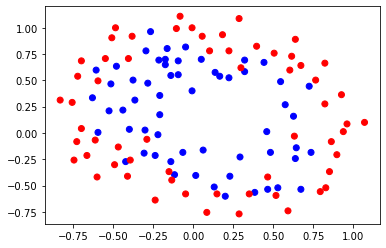

In [25]:
plot_data(X, Y)

In [46]:
#cls = DeepNeuralNet(layer_dims = [2,2,1] , learning_rate = 0.5, num_iter = 4000)
#cls = DeepNeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 4000)
#cls = DeepNeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 10000)
#cls = SoftmaxNeuralNet(layer_dims = [2,20,6,1], normalize = True, learning_rate = 0.5, num_iter = 4000) # easy overfit
cls = SoftmaxNeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 4000)

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

Cost after iteration 0: 0.693212
Cost after iteration 100: 0.618415
Cost after iteration 200: 0.509754
Cost after iteration 300: 0.406367
Cost after iteration 400: 0.350948
Cost after iteration 500: 0.332885
Cost after iteration 600: 0.336381
Cost after iteration 700: 0.329994
Cost after iteration 800: 0.325880
Cost after iteration 900: 0.323433
Cost after iteration 1000: 0.322746
Cost after iteration 1100: 0.321723
Cost after iteration 1200: 0.321358
Cost after iteration 1300: 0.320927
Cost after iteration 1400: 0.320451
Cost after iteration 1500: 0.320344
Cost after iteration 1600: 0.320425
Cost after iteration 1700: 0.320207
Cost after iteration 1800: 0.320063
Cost after iteration 1900: 0.319721
Cost after iteration 2000: 0.319965
Cost after iteration 2100: 0.319753
Cost after iteration 2200: 0.319716
Cost after iteration 2300: 0.319580
Cost after iteration 2400: 0.319498
Cost after iteration 2500: 0.319585
Cost after iteration 2600: 0.319480
Cost after iteration 2700: 0.319510
Cost

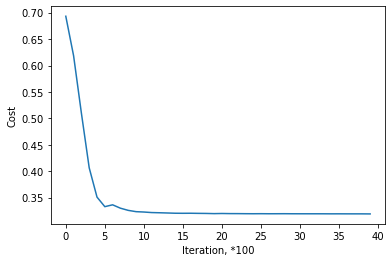

In [48]:
cls.fit(X_train, Y_train)

In [49]:
print(cls.parameters)

{'W1': array([[ 3.50348581e-01, -1.06635080e+00],
       [ 3.25072914e-01, -9.95625520e-01],
       [ 2.38415870e-01, -7.22642509e-01],
       [ 3.90128498e-01,  2.63069492e-01],
       [-1.10279806e-02,  2.00556755e-01],
       [-1.39763190e-02,  2.57798832e-01],
       [-1.50397776e+00, -3.93540053e-01],
       [ 2.94631453e-05, -7.23654718e-06],
       [ 5.14205639e-01,  3.50975203e-01],
       [-1.18840972e-01,  1.82715412e+00],
       [ 7.46919068e-04,  4.05466598e-04],
       [ 2.91104476e-01,  1.98257695e-01],
       [ 9.75891285e-01,  6.60510344e-01],
       [ 1.85435911e-01,  1.25737494e-01],
       [-1.22608966e-03,  2.22247471e-02],
       [ 7.21429202e-01,  4.92685926e-01],
       [-2.03137401e-01,  1.13601723e+00],
       [-1.44918184e+00, -3.74565005e-01],
       [ 4.00005565e-01,  2.72903417e-01],
       [ 1.08713448e+00,  7.30315527e-01]]), 'b1': array([[ 7.46102304e-02],
       [ 6.90895374e-02],
       [ 5.03791776e-02],
       [-2.77153770e-01],
       [ 1.76415687e+

In [50]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[8.08962958e-01, 1.91037042e-01],
       [8.99117191e-01, 1.00882809e-01],
       [9.95818595e-01, 4.18140532e-03],
       [9.40419863e-02, 9.05958014e-01],
       [6.77050853e-03, 9.93229491e-01],
       [1.65604152e-02, 9.83439585e-01],
       [9.76867404e-01, 2.31325961e-02],
       [3.21843508e-01, 6.78156492e-01],
       [2.52910664e-02, 9.74708934e-01],
       [4.22801925e-01, 5.77198075e-01],
       [2.02513688e-05, 9.99979749e-01],
       [8.52464638e-04, 9.99147535e-01],
       [1.47960802e-02, 9.85203920e-01],
       [9.91210541e-03, 9.90087895e-01],
       [5.73509498e-03, 9.94264905e-01],
       [2.21205731e-02, 9.77879427e-01],
       [2.26570709e-01, 7.73429291e-01],
       [3.04289851e-02, 9.69571015e-01],
       [7.96905288e-01, 2.03094712e-01],
       [7.59141400e-01, 2.40858600e-01],
       [7.34013244e-01, 2.65986756e-01],
       [9.58794677e-01, 4.12053226e-02],
       [5.64357816e-02, 9.43564218e-01],
       [4.74777779e-01, 5.25222221e-01],
       [1.486716

In [51]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

In [52]:
accuracy_score(Y_train, Y_train_hat)

0.8829787234042553

In [53]:
accuracy_score(Y_test, Y_test_hat)

0.875

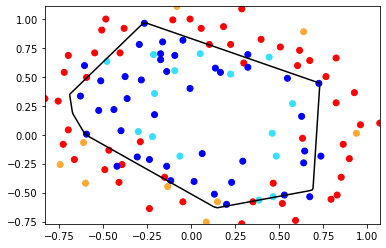

In [54]:
plot_data(X_train, Y_train.reshape((Y_train.shape[0],)))#_train
plot_data(X_test, Y_test.reshape((Y_test.shape[0],)), color_map = cm_bright_test)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [39]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [40]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

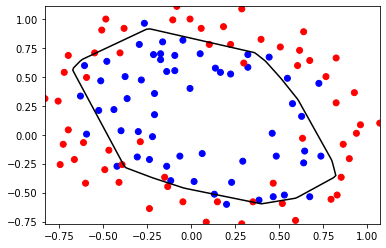

In [41]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [42]:
accuracy_score(Y, clf.predict(X))

0.847457627118644

In [ ]:
m.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
mean_squared_error(y_test, y_pred) 